In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import lucid
import lucid.nn as nn
import lucid.nn.functional as F
import lucid.optim as optim
import lucid.transforms as transforms

from lucid.data import Dataset, DataLoader
from lucid.models.util import summarize

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_path="list_attr_celeba.txt", transform=None):
        self.root_dir = os.path.join(root_dir, "img_align_celeba")
        self.attr_path = os.path.join(root_dir, attr_path)
        self.transform = transform

        with open(self.attr_path, 'r') as f:
            lines = f.readlines()
        self.attr_names = lines[1].strip().split()
        self.attrs = pd.read_csv(self.attr_path, skiprows=2, delim_whitespace=True, index_col=0)
        self.attrs = self.attrs.astype({col: int for col in self.attrs.columns})
        self.attrs = (self.attrs + 1) // 2
        
        self.filenames = self.attrs.index.tolist()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        image = image.transpose((2, 0, 1))

        attr = self.attrs.loc[img_name].values.astype("float32")

        if self.transform:
            image = self.transform(image)

        return image, attr

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(dtype=lucid.Int16),
    transforms.Resize(128),
    transforms.CenterCrop(128),
])

train_dataset = CelebADataset(root_dir=".data/celeba/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

/var/folders/bx/znht11yx04j9q74ngjv7xvwh0000gn/T/ipykernel_34429/793879903.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.attrs = pd.read_csv(self.attr_path, skiprows=2, delim_whitespace=True, index_col=0)


In [4]:
for images, attrs in train_loader:
    print(images.shape)
    print(attrs.shape)
    break

(64, 3, 128, 128)
(64, 40)


In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        hidden_dims = [32, 64, 128, 256, 512]
        self.final_dim = hidden_dims[-1]
        self.latent_dim = latent_dim
        in_channels = 3
        
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4 * 4, self.latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1] * 4 * 4, self.latent_dim)
        
        modules = []
        self.decoder_input = nn.Linear(self.latent_dim, hidden_dims[-1] * 4 * 4)
        
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )
        
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        ret = self.encoder(x)
        ret = lucid.flatten(ret, axis=1)
        mu = self.fc_mu(ret)
        logvar = self.fc_logvar(ret).clip(-10.0, 10.0)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = lucid.exp(0.5 * logvar)
        eps = lucid.random.randn(*std.shape, device=std.device)
        return eps * std + mu
    
    def decode(self, z):
        ret = self.decoder_input(z)
        ret = ret.reshape(-1, self.final_dim, 4, 4)
        ret = self.decoder(ret)
        ret = self.final_layer(ret)
        return ret
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
device = "gpu"

model = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

summarize(model, input_shape=(1, 3, 128, 128), test_backward=True)

                                        Summary of VAE                                         
Layer                               Input Shape           Output Shape          Parameter Size
VAE                                 (1, 3, 128, 128)      None                  6,303,075   
├── Sequential                      (1, 32, 64, 64)       (1, 3, 128, 128)      10,179      
├── Sigmoid                         (1, 3, 128, 128)      (1, 3, 128, 128)      -
├── Conv2d                          (1, 32, 128, 128)     (1, 3, 128, 128)      867         
├── LeakyReLU                       (1, 32, 128, 128)     (1, 32, 128, 128)     -
├── BatchNorm2d                     (1, 32, 128, 128)     (1, 32, 128, 128)     64          
├── ConvTranspose2d                 (1, 32, 64, 64)       (1, 32, 128, 128)     9,248       
├── Sequential                      (1, 512, 4, 4)        (1, 32, 64, 64)       1,568,160   
├── Sequential                      (1, 64, 32, 32)       (1, 32, 64, 64)       18,528 

In [7]:
def normalize(img):
    ret = img.astype(lucid.Float32) / 255.0
    return ret

In [8]:
def loss_function(recon_x, x, mu, logvar):
    mse = F.mse_loss(recon_x, x, reduction="mean")
    kld = -0.5 * lucid.mean(1 + logvar - mu ** 2 - lucid.exp(logvar))
    kld_weight = 0.0005
    loss = mse + kld_weight * kld
    return loss

In [9]:
def train(num_epochs):
    losses = []
    model.train()
    for epoch in range(num_epochs):
        batch_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        for data, _ in pbar:
            data = data.to(device)
            data = normalize(data)
            optimizer.zero_grad()
            recon_data, mu, logvar = model(data)
            
            loss = loss_function(recon_data, data, mu, logvar)
            loss.eval()
            loss.backward()
            optimizer.step()

            loss_value = loss.item()
            batch_losses.append(loss_value)

            avg_loss = sum(batch_losses) / len(batch_losses)
            pbar.set_postfix(loss=loss_value, avg_loss=avg_loss)
        
        losses.extend(batch_losses)

    return losses

In [ ]:
losses = train(num_epochs=10)

In [ ]:
plt.plot(losses, lw=1, label="Recon + KL-Div")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("VAE Training for CelebA Dataset")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

'\nplt.plot(losses, lw=1, label="Recon + KL-Div")\nplt.xlabel("Iteration")\nplt.ylabel("Loss")\nplt.title("VAE Training for CelebA Dataset")\nplt.grid(alpha=0.3)\nplt.legend()\nplt.tight_layout()\n'

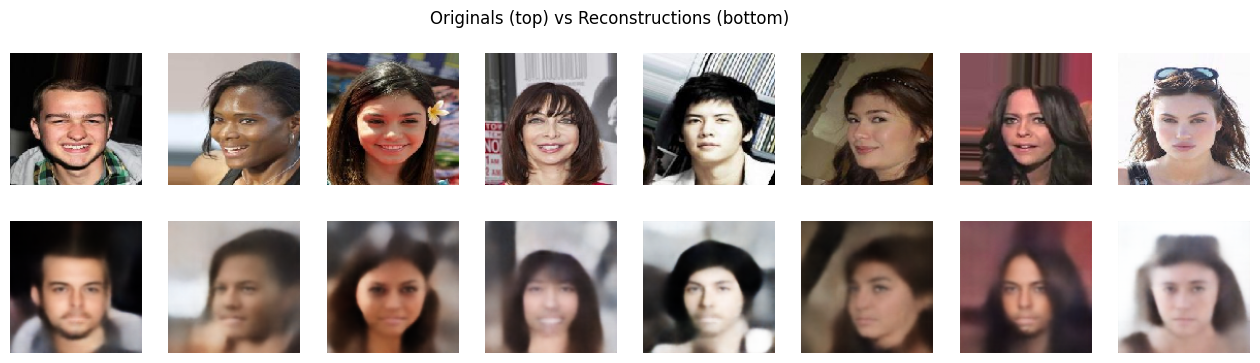

In [13]:
def show_reconstructions(model, data_loader, device):
    model.eval()
    with lucid.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            data = normalize(data)
            recon, _, _ = model(data)
            break

    imgs = data[:8].numpy()
    recons = recon[:8].numpy()

    import matplotlib.pyplot as plt
    _, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(imgs[i].transpose((1, 2, 0)))
        axes[1, i].imshow(recons[i].transpose((1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.suptitle("Originals (top) vs Reconstructions (bottom)")
    plt.show()

show_reconstructions(model, train_loader, device)

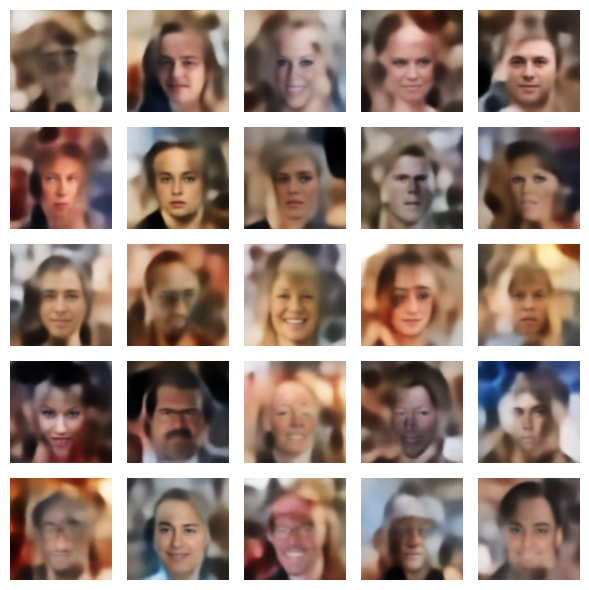

In [14]:
def generate_image_grid(latent_dim=128, grid_size=5):
    model.eval()
    with lucid.no_grad():
        # Sample z ~ N(0, 1)
        z = lucid.random.randn(grid_size * grid_size, latent_dim).to(device)
        out = model.decode(z).numpy()

    # Clamp to [0, 1] range in case of minor noise
    out = out.clip(0, 1)

    # Plot as 5x5 grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    for i in range(grid_size * grid_size):
        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(out[i].transpose((1, 2, 0)))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

generate_image_grid()